In [274]:
import importlib, sys, matplotlib.pyplot as plt, matplotlib.patheffects as pe, sereias
importlib.reload(sereias) 

# ok, REALLY make sure that the starlet sereias is really reloaded :D I cannot stop loathing Python... why do we need to do this?!!?!

<module 'sereias' from '/home/algol/CRP8/Undine/sereias.py'>

In [234]:
# Just a first test with a random cube... Positive + sparse starlet (not perfectly reconstructing by design; but residual map will be stored!)
# Example cube: (x, y, λ)
cube = np.random.default_rng(0).normal(size=(256, 256, 10))
scales, residual = sereias.starlet_decompose_cube(cube, 4, positive=True, k_sigma=3.0, return_residual=True)
print([s.shape for s in scales], residual.shape)  # all (x, y, λ)

[(256, 256, 10), (256, 256, 10), (256, 256, 10), (256, 256, 10)] (256, 256, 10)


In [235]:
# Exact reconstruction (disable positivity constraints)
scales, residual = sereias.starlet_decompose_cube(cube, 4, positive=False, k_sigma=None, return_residual=True)
recon = sum(scales) + residual
print("rel. error:", np.linalg.norm(cube - recon)/np.linalg.norm(cube))  
# residuals should be around ~1e-16... just for sanity check!

rel. error: 1.0500531976457295e-16


In [241]:
# Time benchmark... just to see how long it could take for largish cubes
import time

# create the benchmark cube
cube = np.random.default_rng(0).normal(size=(512, 512, 10))

start_time = time.perf_counter()
# 4-scale positive starlet, sparse via 3σ soft-thresholding, and also return residual...
scales, residual = sereias.starlet_decompose_cube(cube, n_scales=4, k_sigma=3.0, return_residual=True)
end_time = time.perf_counter()
# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The cube segmentation took: {elapsed_time:.6f} seconds\n Cube shape and number of scales info: ")
# Each element in `scales` is a (x, y, λ) cube for that scale:
print(len(scales), scales[0].shape)   # -> 4 (256, 256, 10)

The cube segmentation took: 2.158115 seconds
 Cube shape and number of scales info: 
4 (512, 512, 10)


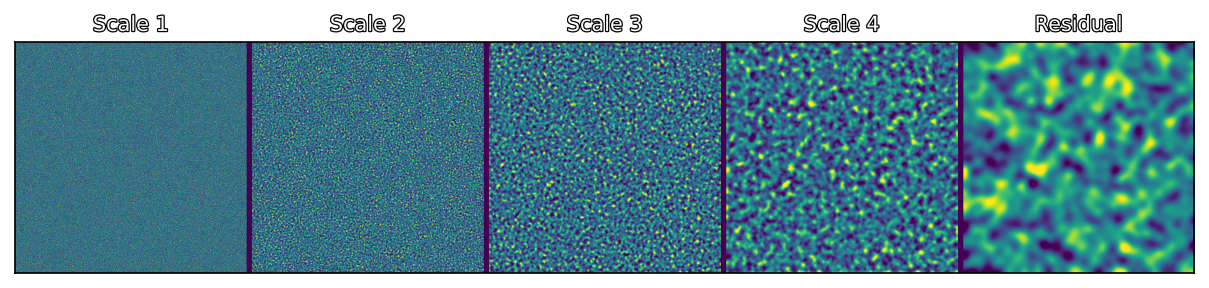

In [252]:
mosaic, labels, anchors = sereias.starlet_scales_mosaic(scales, residual=residual, lambda_index=None, aggregate="sum")
# Render a plot of the decomposition test
fig = plt.figure(dpi=150, figsize=(8, 6))
ax = plt.gca()
ax.imshow(mosaic, vmin=0.0, vmax=1.0)
ax.set_xticks([]); ax.set_yticks([])

for i, a in enumerate(anchors):
    txt = ax.text(
        a["x"] + a["w"]/2, 
        a["y"] - 15,
        f"{labels[i]}",
        ha="center", va="bottom", fontsize=10, color="white"
    )
    # thin black stroke for contrast (optional)
    txt.set_path_effects([pe.withStroke(linewidth=1.2, foreground="black")])

plt.tight_layout(pad=0.5)

In [254]:
# Ok,now that we know it kind of looks like it works... let's try doing some science... 

cube, info = sereias.read_fits_cube(
    "./datacube_reg1.fits",
    hdu=None,                     # or an index or ext name
    squeeze_singletons=True,
    slice_axes=None,              # e.g. {0:0} if there’s a Stokes axis first!
    assume_spectral_first=True,
)

In [255]:
# Now do the starlet
scales, residual = sereias.starlet_decompose_cube(cube, n_scales=4, k_sigma=2.0, return_residual=True)

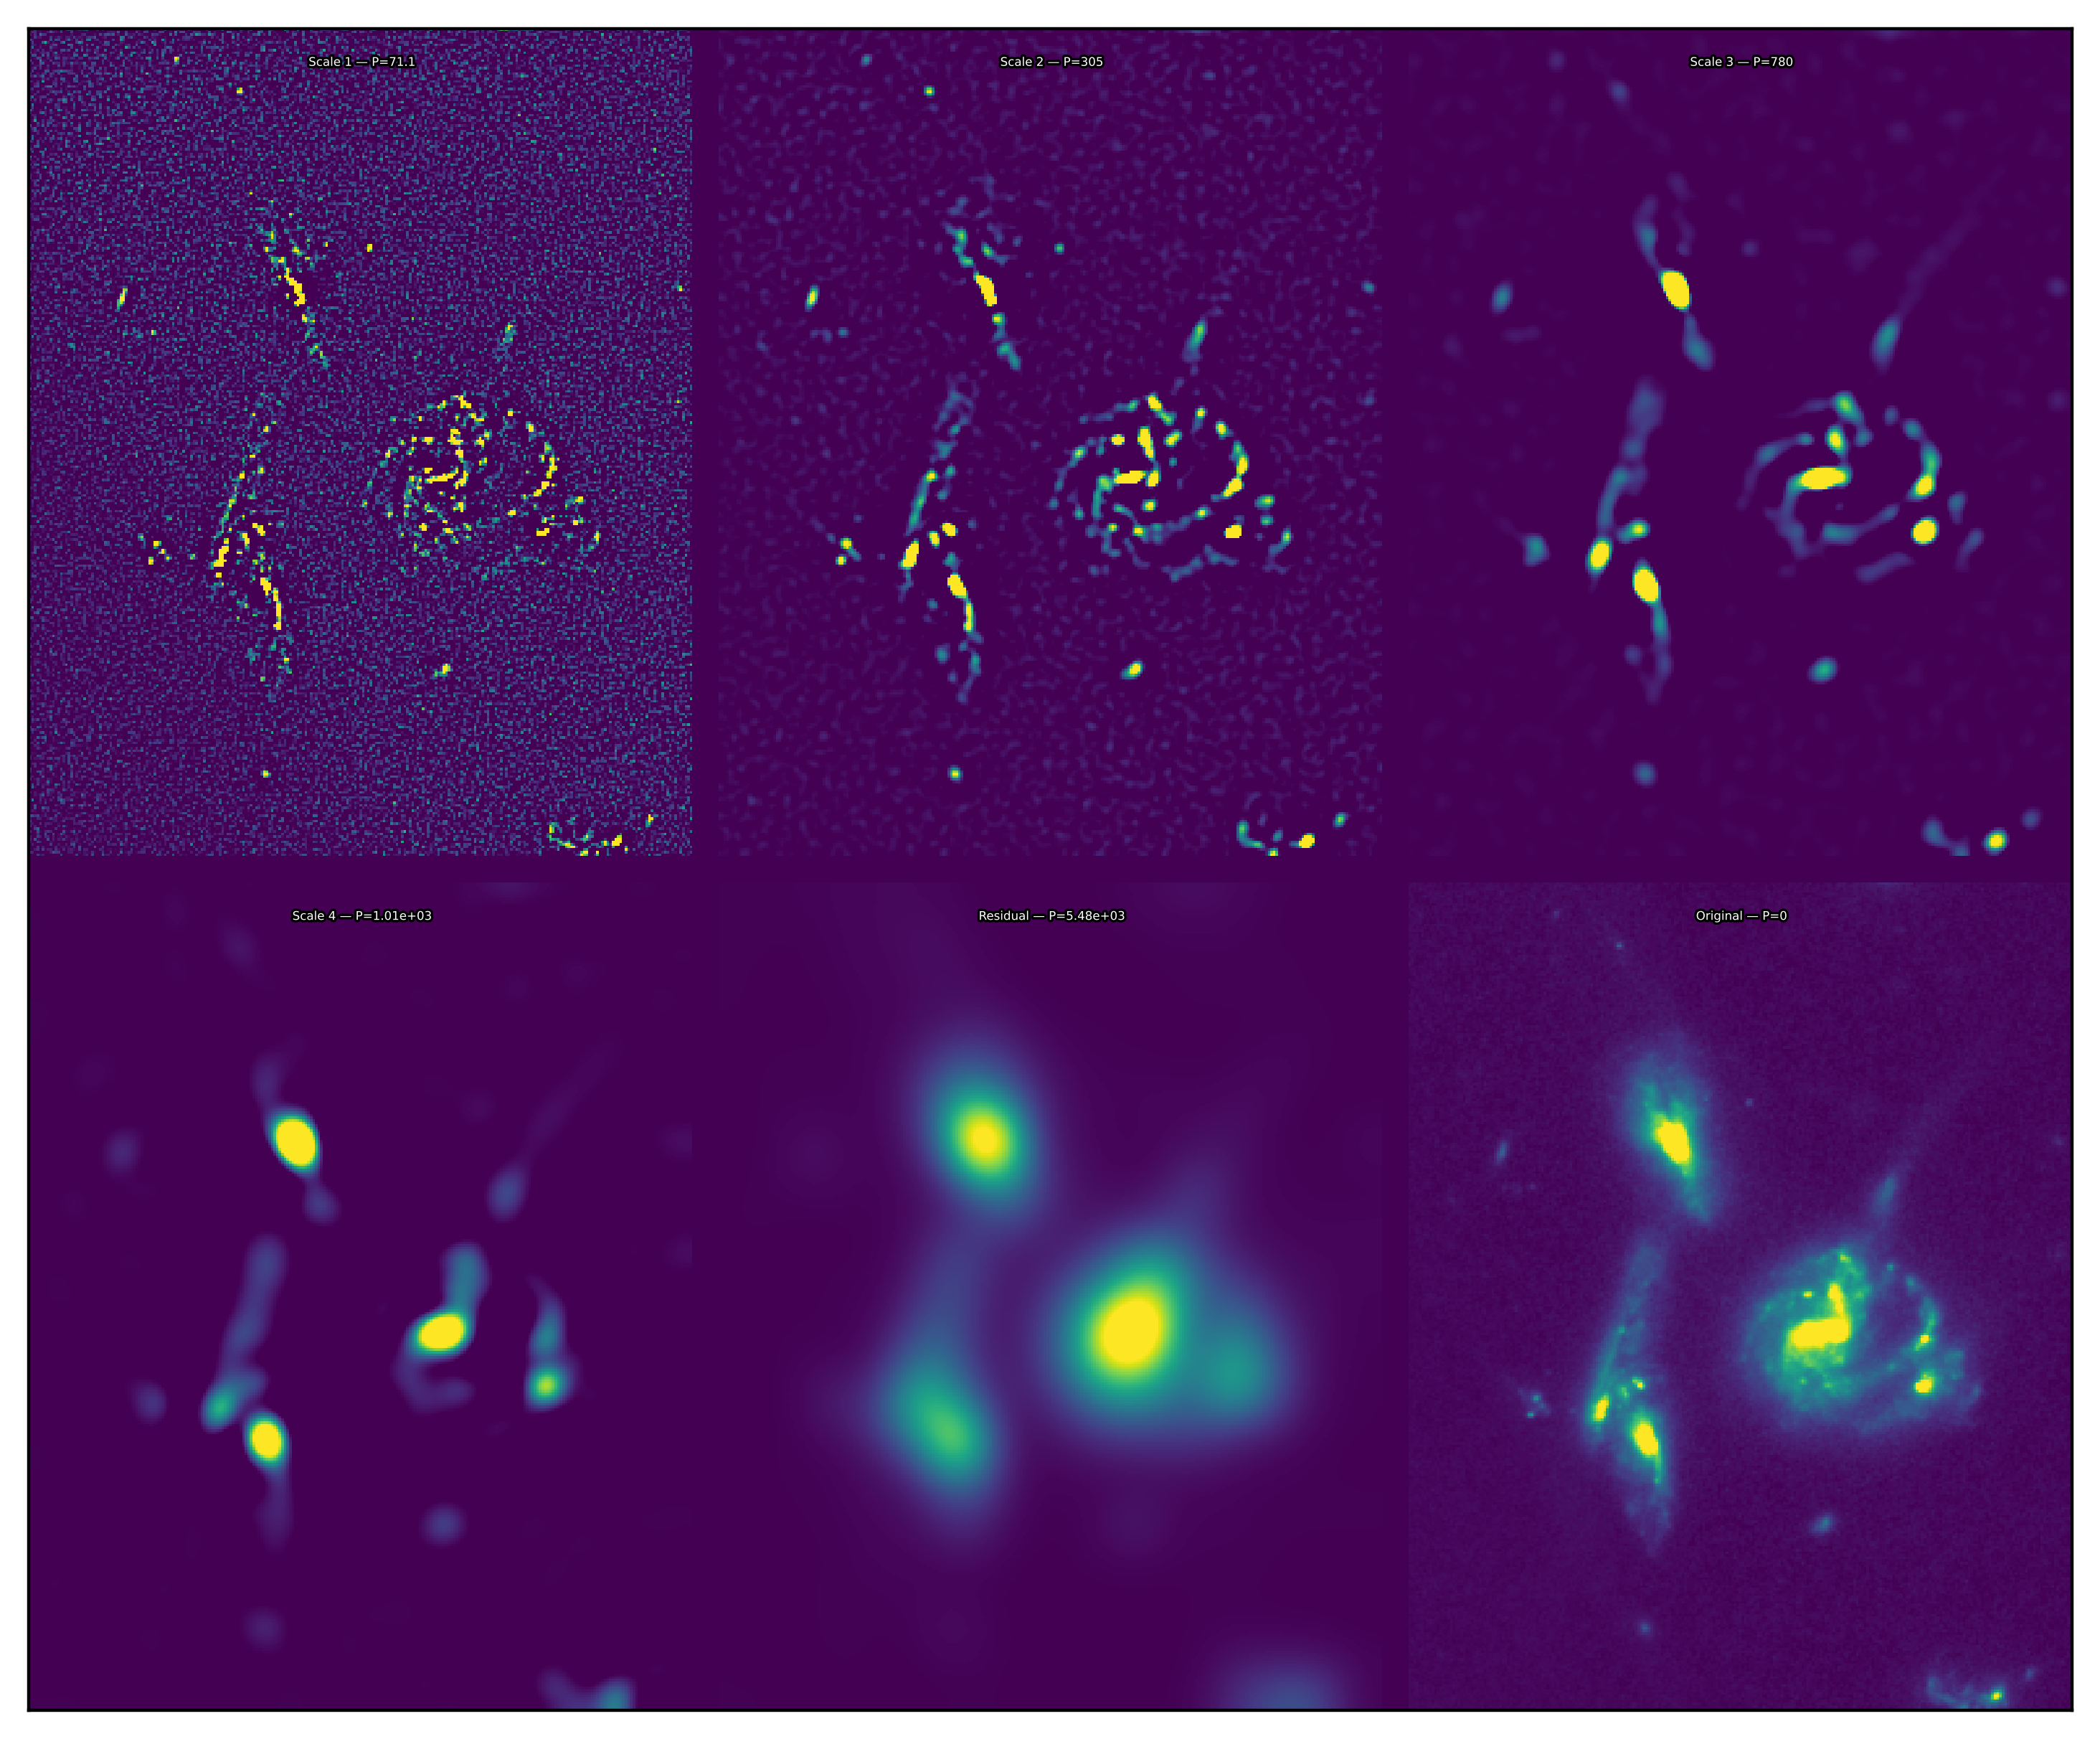

In [257]:
# Lets now create a plot showing all the currently decomposed scales...
mosaic, labels, anchors = sereias.starlet_scales_mosaic(
    scales, residual=residual,
    lambda_index=1,      # or an int to use a specific λ-slice
    aggregate="sum",
    ncols=3,                
    gap_px=10,
    original=cube,           # pass the original cube to append as the final tile
    original_label="Original"
)

# Compute the total powers at a certain scale (default L2 over all λ)
powers, pres = sereias.starlet_scale_powers(scales, residual=residual, lambda_index=None, kind="l2")
powers_fmt = [f"{p:.3g}" for p in powers] + ([f"{pres:.3g}"] if pres is not None else [])

# Render with white labels including power
fig = plt.figure(dpi=400, figsize=(8, 6))
ax = plt.gca()
ax.imshow(mosaic, vmin=0.0, vmax=1.0)
ax.set_xticks([]); ax.set_yticks([])

powers_fmt.append("0") # Just to make sure the code won't complain (because it is not calculating any power for the full image)

for i, a in enumerate(anchors):
    txt = ax.text(
        a["x"] + a["w"]/2, 
        a["y"] + 15,
        f"{labels[i]} — P={powers_fmt[i]}",
        ha="center", va="bottom", fontsize=3, color="white"
    )
    # thin black stroke for contrast (optional)
    txt.set_path_effects([pe.withStroke(linewidth=1.2, foreground="black")])

plt.tight_layout(pad=0.5)

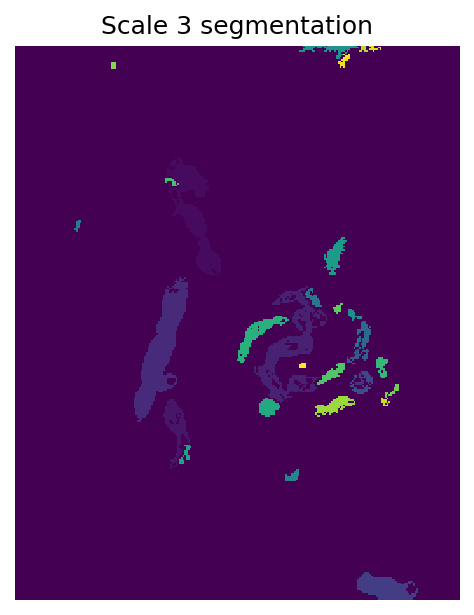

In [258]:
# Cool, now lets try to get a segmentation of at least one scale...

# Choose a scale j (1-indexed in my head, but Python list is 0-indexed as well, typical from C...)
j = 3
wj = scales[j-1]  # (x,y,λ) decomposed at the scale we want...

labels = sereias.segment_starlet_scale_region_growing(
    cube, wj,
    spectra_source="original",   # or "detail"
    saliency_mode="l2",
    seed_quantile=0.90,
    connectivity=8,
    cos_sim_min=0.9,
    min_region=10,
    merge_cos_min=0.92,
)

plt.figure(dpi=150); 
plt.imshow(labels, interpolation="nearest"); plt.axis("off"); plt.title(f"Scale {j} segmentation");


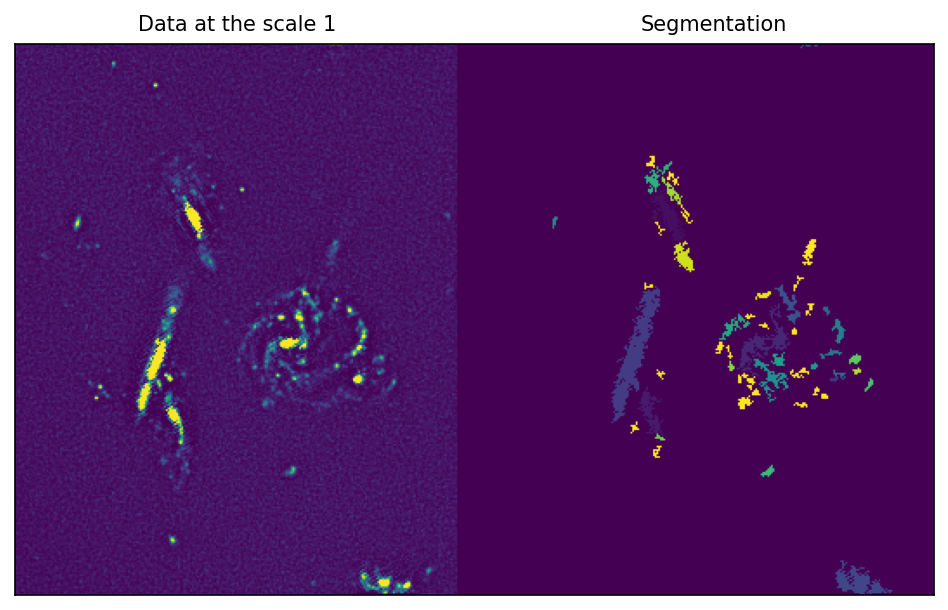

In [271]:
# Now with a comparison between the wavelet image at a certain scale and the segmentation at the same scale...
# pick a scale (Python index is 0-based... REMEMBER! crap... memoria de como fazia no R o tempo todo... )
scale = 1
wj = scales[scale-1]

labels = sereias.segment_starlet_scale_region_growing(
    cube, wj,
    spectra_source="original",   # or "detail"
    saliency_mode="l2",
    seed_quantile=0.90,
    connectivity=8,
    cos_sim_min=0.9,
    min_region=10,
    merge_cos_min=0.92,
)  # the (x,y) segmentation for that wavelet scale

mosaic, anchors = sereias.compose_scale_and_seg_per_scale(
    wj, labels,
    lambda_index=None,       # or an int for a specific λ plane
    aggregate="sum",
    gap_px=20,
    left_title=f"Data at the scale {scale}",
    right_title="Segmentation",
)

fig = plt.figure(dpi=150, figsize=(10, 4))
ax = plt.gca()
ax.imshow(mosaic, vmin=0.0, vmax=1.0)   # single image, no subplots
ax.set_xticks([]); ax.set_yticks([])

for a in anchors:
    ax.text(a["x"], a["y"], a["text"], ha="center", va="bottom", fontsize=10)
plt.tight_layout(pad=0.5)

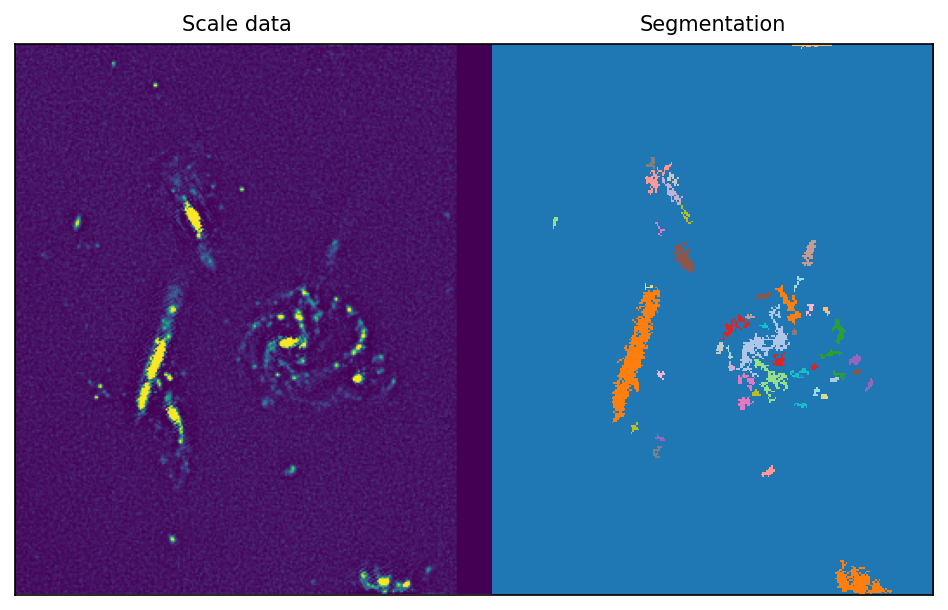

In [279]:
# wj: ,y (x,y,λ) scale cube, labels: my (x,y) segmentation (ints)

# Just do the plot directly from a previous wj; a simpler function call than the one we previously wrote... 
# and with a configurable colormap...

fig, ax, size, anchors = sereias.compose_scale_and_seg(
    wj, labels,
    lambda_index=None,      # or an int to pick a specific λ
    aggregate="sum",
    gap_px=20,
    left_title="Scale data",
    right_title="Segmentation",
    overlay_boundaries=True, boundary_linewidth=0, boundary_alpha=0.5,
    seg_cmap_name="tab20"
)

In [305]:
# Lets now create the segmentation for all scales individually

per_scale_labels: list[np.ndarray] = []
for j in range(len(scales)):
    wj = scales[j]
    labels_j = sereias.segment_starlet_scale_region_growing(
        cube, wj,
        spectra_source = "original",   # 'original' | 'detail' detail will use the fraction of the flux at that wavelet scale and wavelength
        saliency_mode = "l2",
        seed_quantile = 0.90,        
        connectivity= 8,              
        cos_sim_min = 0.90,          # spectral similarity threshold (0..1)
        min_region = 10,               # drop or merge tiny blobs
        normalize = "unit",            
        merge_cos_min = 0.92,        # optional post-merge threshold
        return_debug = False
        )
    per_scale_labels.append(labels_j.astype(np.int32, copy=False))

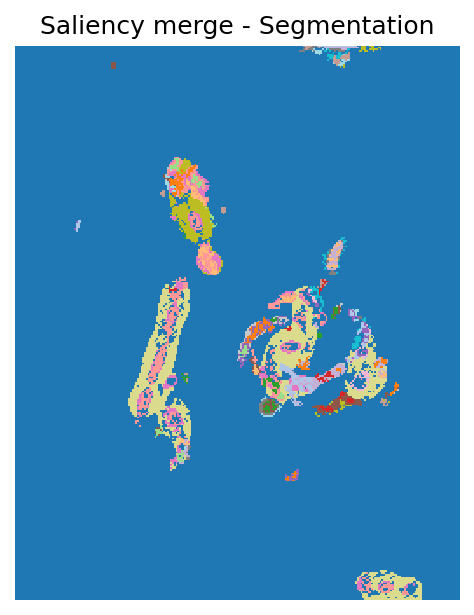

In [307]:
# ok, now lets start merging detected regions between scales...
# inputs:
# scales: list of (x,y,λ) detail cubes w_j
# segs:   list of (x,y) label maps from each scale (0=background)

# 1) Saliency-driven merge (per-pixel max saliency wins; fine scales break ties)
final_labels, info = sereias.merge_scale_segmentations(
    per_scale_labels,
    scale_cubes=scales,          # lets it compute saliency as L2 energy of each w_j
    saliency_mode="l2",
    method="argmax",
    priority="fine_first",
    normalize="per",
    relabel_compact=False,       # keep per-scale offsets in ids
)
plt.figure(dpi=150); 
plt.imshow(final_labels, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Saliency merge - Segmentation");

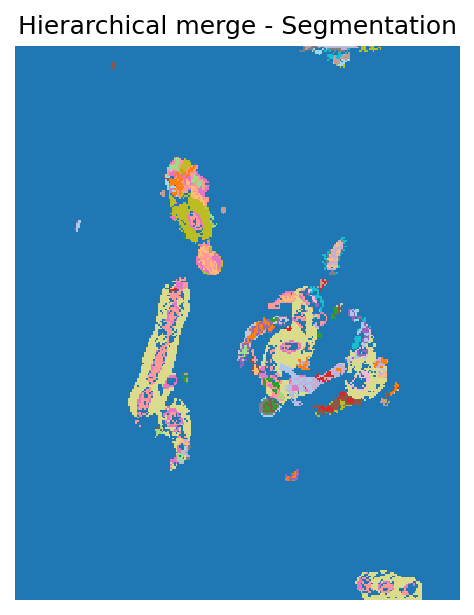

In [308]:
# 2) Simple hierarchical merge (fill from fine → coarse; never overwrite)
final_labels_fw, info_fw = starlet_cube.merge_scale_segmentations(
    per_scale_labels,
    method="first-wins",
    priority="fine_first",
)
plt.figure(dpi=150); 
plt.imshow(final_labels, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Hierarchical merge - Segmentation");

In [309]:
#### Getting more serious, instead of the step by step, just do the full procedure cube->segmented labels
#
# Lets do the entire process directly from a numpy cube
#
labels_final, info = sereias.starlet_segment_cube(
    cube, n_scales=4,
    positive=True, k_sigma=2.0,                 # decomposition
    # optional per-scale segmentation tweaks
    segmentation_params=dict(
        seed_quantile=0.95,
        cos_sim_min=0.80,
        min_region=10,
        normalize="unit",                        # spectra normalization
        connectivity=8,
    ),
    # fusion behavior
    fusion_method="argmax", 
    fusion_priority="fine_first",
    fusion_saliency_mode="l2",
    fusion_normalize="per",
    relabel_compact=True,
)

In [310]:
# Which are the unique labels?
#labels_final
print("--------------------------------------------------")
unique_values = np.unique(labels_final)
print(unique_values)
print("--------------------------------------------------")
print(f"There are {len(unique_values)} detected regions in the data cube.")
print("--------------------------------------------------")

--------------------------------------------------
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111]
--------------------------------------------------
There are 112 detected regions in the data cube.
--------------------------------------------------


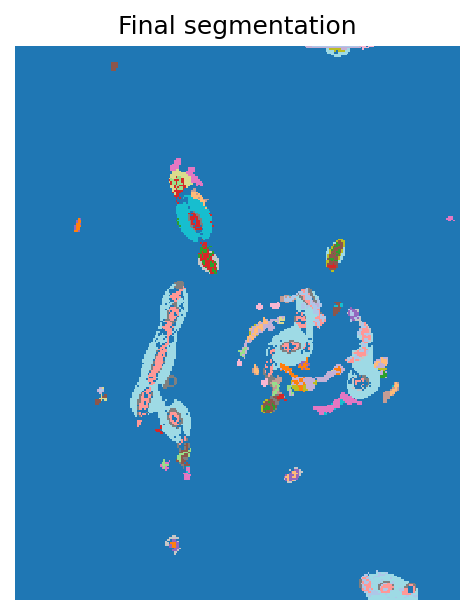

In [311]:
plt.figure(dpi=150); 
plt.imshow(labels_final, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Final segmentation");

In [302]:
# Save resulting segmentation map to a fits file for the rest of the pipeline...

from astropy.io import fits
hdu = fits.PrimaryHDU(labels_final.astype(np.int32))
hdu.writeto("datacube_reg1_segmentationmap.fits", overwrite=True)

In [303]:
labels_refined, refinfo = sereias.refine_labels_by_sed_adjacency(
    labels_final, cube,
    connectivity=4,      # or 4
    min_size=20,         # tweak based on your data
    sim_threshold=0.9,  # tighten/loosen as needed
    max_passes=3,
    prefer_larger=True,
    normalize="unit",    # continuum-removed + unit-length per pixel
    compact_ids=True,
    return_info=True,
)

print(refinfo)  # view how many merges/passes happened


{'passes': 3, 'merges': 72, 'sim_threshold': 0.9, 'connectivity': 4, 'min_size': 20}


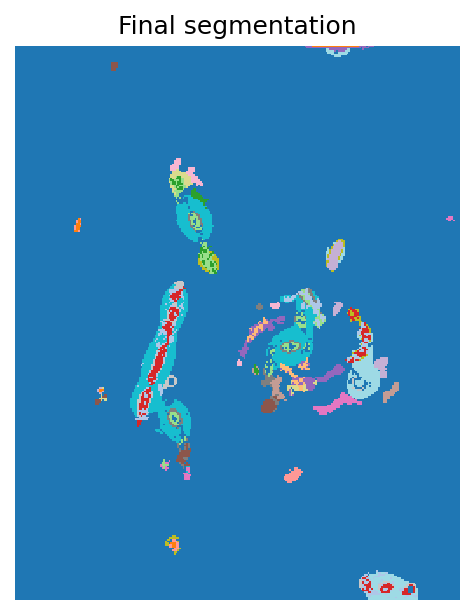

In [304]:
plt.figure(dpi=150); 
plt.imshow(labels_refined, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Final segmentation");

In [286]:
# Which are the unique labels?
#labels_final
print("--------------------------------------------------")
unique_values = np.unique(labels_refined)
print(unique_values)
print("--------------------------------------------------")
print(f"There are {len(unique_values)} detected regions in the data cube.")
print("--------------------------------------------------")

--------------------------------------------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
--------------------------------------------------
There are 76 detected regions in the data cube.
--------------------------------------------------


In [287]:
# Save resulting segmentation map to a fits file for the rest of the pipeline...

from astropy.io import fits
hdu = fits.PrimaryHDU(labels_final.astype(np.int32))
hdu.writeto("datacube_reg1_segmentationmap_refined.fits", overwrite=True)

In [ ]:
# Done! If we arrived here, we now just need to actually create a package and its documentation...
# cool!